# How much does it cost for homestays when you use Airbnb service?
This project is using Seattle Airbnb dataset: https://www.kaggle.com/datasets/airbnb/seattle

## Three business questions:
#### 1. What kinds of homestay are there?
#### 2. Which homestay is the most recommended, house or apartment?
#### 3. What aspects correlate well to the price and how well can we predict it?

Firstly, let's look at the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdic
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

df = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [3]:
# Number of rows and columns in Dataset
num_rows = df.shape[0]
num_cols = df.shape[1]
print(f'There are {num_rows} rows and {num_cols} columns')

There are 3818 rows and 92 columns


## 1. What kinds of homestay are there?

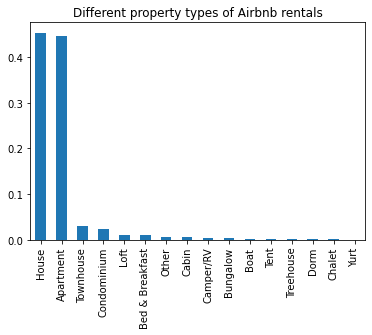

In [4]:
# The below is a bar chart of the proportion of property_type
property_type_vals = df['property_type'].value_counts()
(property_type_vals/df.shape[0]).plot(kind='bar');
plt.title("Different property types of Airbnb rentals");

In [10]:
print(f'The proportion of House is {property_type_vals["House"]/df.shape[0]}')
print(f'The proportion of Apartment is {property_type_vals["Apartment"]/df.shape[0]}')

The proportion of House is 0.45390256678889473
The proportion of Apartment is 0.44735463593504454


The dataset shows that there are many of Airbnb rentals, the proportion of House and Apartment accounts for the most.

Therefore, I will focus on House and Apartment.

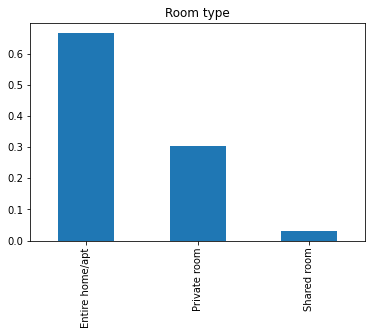

In [25]:
# The below is a bar chart of the proportion of room_type
room_type_vals = df['room_type'].value_counts()
(room_type_vals/df.shape[0]).plot(kind='bar');
plt.title("Room type");

There are only three types of rooms in the dataset: Entire home/apt, Private room and Shared room

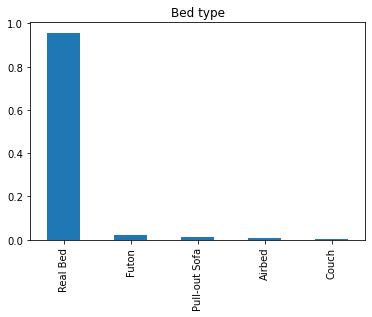

In [26]:
# The below is a bar chart of the proportion of bed_type
bed_type_vals = df['bed_type'].value_counts()
(bed_type_vals/df.shape[0]).plot(kind='bar');
plt.title("Bed type");

## 2. Which homestay is the most recommended, house or apartment?
To answers this question, choose the most reviews house and apartment first

In [45]:
# Filter out the House and Apartment types.
house_df = df[df['property_type'] == 'House']
apt_df = df[df['property_type'] == 'Apartment']

# Index with most reviewed
house_idx_most_reviewed = house_df['number_of_reviews'].idxmax()
apt_idx_most_reviewed = apt_df['number_of_reviews'].idxmax()

# Choose the most reviewed homestays
house_most_reviewed = house_df.loc[house_idx_most_reviewed]
apt_most_reviewed = apt_df.loc[apt_idx_most_reviewed]

print(f"The id of most reviewed house: {house_most_reviewed['id']}")
print(f"Number reviews of most reviewed house: {house_most_reviewed['number_of_reviews']}")
print(f"The id of most reviewed apartment: {apt_most_reviewed['id']}")
print(f"Number reviews of most reviewed apartment: {apt_most_reviewed['number_of_reviews']}")

The id of most reviewed house: 25002
Number reviews of most reviewed house: 404
The id of most reviewed apartment: 92835
Number reviews of most reviewed apartment: 319


In [77]:
def get_comments(listing_id: int, reviews: pd.DataFrame = reviews):
    '''
    INPUT - listing_id - int - the id of homestay you would like to know about
            reviews - pandas dataframe with the reviews of the survey
    OUTPUT - 
            comments - Series - series of comments
    '''
    reviews_id = reviews[reviews['listing_id'] == listing_id]
    comments = reviews_id['comments']
    
    return comments

In [78]:
# Test comments
listing_id = house_most_reviewed['id']
comments = get_comments(listing_id)
print(comments.value_counts().reset_index())

                                                 index  comments
0    Lovely!  Very warm and friendly...and the most...         1
1    Amanda was a great host and we had a great tim...         1
2    Easy stay, nice quiet neighborhood but very cl...         1
3    I enjoyed a comfortable 3 day stay at Amanda's...         1
4    Amanda was very friendly and a joy to talk to....         1
..                                                 ...       ...
399  Amanda was an excellent host! We had a late fl...         1
400  This place was in a beautiful and quiet neighb...         1
401  We stayed for 3 nights in June and had a wonde...         1
402  \r\n\r\nAmanda was awesome. My girlfriend & I ...         1
403  Amanda's studio was perfect for our nine-day s...         1

[404 rows x 2 columns]


In [79]:
# Utilize total_count function from lession 2
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [102]:
# Choose some most common words from most reviewed homestay to evaluate
possible_vals = ['stay here again', 'comfortable', 'convenient']
comments = get_comments(house_most_reviewed['id'])
house_comment = comments.value_counts().reset_index()
house_comment.rename(columns={'index': 'common comment', 'comments': 'count'}, inplace=True)
house_comment_df = total_count(house_comment, 'common comment', 'count', possible_vals)
house_comment_df['rental type'] = 'house'
house_comment_df

,common comment,count,rental type
1,comfortable,156,house
0,stay here again,34,house
2,convenient,27,house


In [103]:
comments = get_comments(apt_most_reviewed['id'])
apt_comment = comments.value_counts().reset_index()
apt_comment.rename(columns={'index': 'common comment', 'comments': 'count'}, inplace=True)
apt_comment_df = total_count(apt_comment, 'common comment', 'count', possible_vals)
apt_comment_df['rental type'] = 'apartment'
apt_comment_df

,common comment,count,rental type
1,comfortable,74,apartment
2,convenient,30,apartment
0,stay here again,25,apartment


In [104]:
df_plot = pd.concat([house_comment_df, apt_comment_df], ignore_index=True)
df_plot

,common comment,count,rental type
0,comfortable,156,house
1,stay here again,34,house
2,convenient,27,house
3,comfortable,74,apartment
4,convenient,30,apartment
5,stay here again,25,apartment


C:\Users\nguye\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


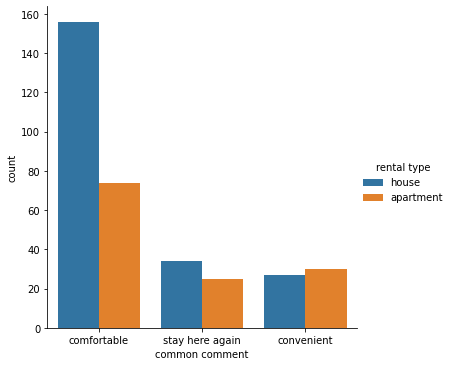

In [105]:
sns.factorplot(x='common comment', y='count', hue='rental type', kind='bar', data=df_plot)

The plot shows that living in a house is more comfortable than an apartment.

In [106]:
# How about the price, let's calculate the mean of price for each
df_price = df.copy()
# Preprocessing the price
df_price['price'] = df_price['price'].apply(lambda x: x.replace(',', '')).apply(lambda x: x.replace('$', '')).astype(float)
df_price.groupby('property_type').mean()['price'].sort_values()

property_type
Dorm                39.500000
Tent                54.000000
Other               94.681818
Chalet              98.500000
Yurt               100.000000
Treehouse          101.000000
Cabin              104.666667
Bed & Breakfast    112.054054
Bungalow           115.615385
Camper/RV          120.461538
Apartment          122.932670
Townhouse          129.457627
House              132.351414
Loft               135.700000
Condominium        151.109890
Boat               282.375000
Name: price, dtype: float64

The average price of House is `$132` and Apartment is `$122`.

If the tenant doesn't mind about comfortable, can choose apartment for an affordable price

## 3. What aspects correlate well to the price and how well can we predict it?

Use the correlation matrix to see which variables are related to one another

In [167]:
df_corr = df_price[[
    'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating',
    'review_scores_value', 'guests_included'
]]

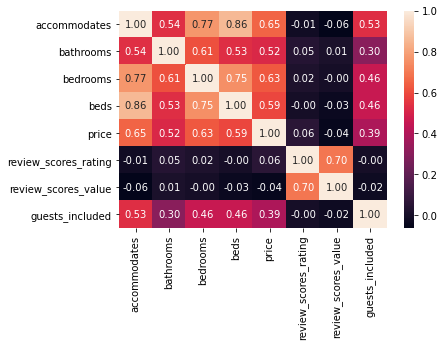

In [168]:
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f");

Build the model to predict the price of a house

In [170]:
# Check the proportion of missing values for each columns
df_corr.isnull().sum() / df_price.shape[0]

is_location_exact       0.000000
accommodates            0.000000
bathrooms               0.004191
bedrooms                0.001572
beds                    0.000262
price                   0.000000
review_scores_rating    0.169460
review_scores_value     0.171818
guests_included         0.000000
dtype: float64

In [188]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''
    # Choose only colums can be used to predict price
    df = df[['is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]
    # Drop row with missing values
    df = df.dropna(axis=0)
    
    # Preprocessing price, convert it to float
    df['price'] = df['price'].apply(lambda x: x.replace(',', '')).apply(lambda x: x.replace('$', '')).astype(float)
    
    #Split into explanatory and response variables
    X = df[['is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds']]
    y = df['price']
    
    # Dummy the categorical variables
    cat_vars = X.select_dtypes(include=['object']).copy().columns
    for var in cat_vars:
        X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return X, y

In [202]:
# Preprocessing data before using it for linear model
X, y = clean_data(df)
print(X.shape)

(3796, 5)


In [198]:
# Training and predict data using clean_dataset

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# Fit the model
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

r2_score_train = r2_score(y_train, y_train_preds)
r2_score_test = r2_score(y_test, y_test_preds)

In [203]:
print('The training r-squared score for the model:', r2_score_train)
print('The test r-squared score for the model', r2_score_test)

The training r-squared score for the model: 0.47867867534517394
The test r-squared score for the model 0.48373257189338126


The model is underfitting, it could not fit the training set well.
The given features are not sufficient to predict the price of using Airbnb service.